In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools.plotting import scatter_matrix

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# get train & test csv files as a DataFrame
titanic_df = pd.read_csv("../Data/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../Data/test.csv", dtype={"Age": np.float64}, )

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# information about the dataframe
titanic_df.info(verbose=True)
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

## Initial Observations ##

- 891 entries in the training set
- 418 entries in the test set
- Both sets have the same columns except the Survived class is (correctly) absent from the test set
- Age and Cabin have a lot of missing values in both data sets
- Embarked and is missing 2 values in the train set only so can probably be removed
- Fare is missing 1 value in the test set only so we will need to substitute a default value

## Basic Cleaning ##

Drop unnecessary columns or rows that won't be useful in analysis and prediction

- Remove PassengerId from train as it is an index and has no value. 
- Cabin might be a potential for removing given there are so many missing values however we need to investigate it further.
- Remove the 2 entries from the training set with missing Embarked values as the % of entries it impacts is so low.

In [4]:
titanic_df = titanic_df.drop(['PassengerId'], axis=1)

titanic_df = titanic_df.dropna(subset=['Embarked'])
titanic_df.info() # verify

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         712 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Cabin       202 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


Basic Statistics
----------
Some basic statistics about the remaining columns

In [5]:
# Get some statistical values for the training data set.
titanic_df.describe()

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,712.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681
std,0.486260,0.834700,14.492933,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.895800
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Get some statistical values for the training data set.
test_df.describe()

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,0.000000,0.000000,NaN
50%,1100.500000,3.000000,NaN,0.000000,0.000000,NaN
75%,1204.750000,3.000000,NaN,1.000000,0.000000,NaN
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
print(titanic_df.corr())

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.335549 -0.082446 -0.034040  0.083151  0.255290
Pclass   -0.335549  1.000000 -0.365902  0.081656  0.016824 -0.548193
Age      -0.082446 -0.365902  1.000000 -0.307351 -0.187896  0.093143
SibSp    -0.034040  0.081656 -0.307351  1.000000  0.414542  0.160887
Parch     0.083151  0.016824 -0.187896  0.414542  1.000000  0.217532
Fare      0.255290 -0.548193  0.093143  0.160887  0.217532  1.000000


In [8]:
print("Survived: " + str(len(titanic_df[titanic_df['Survived'] == 1])))
print("Died: " + str(len(titanic_df[titanic_df['Survived'] == 0])))
print("Total: " + str(len(titanic_df)))


Survived: 340
Died: 549
Total: 889


## Baseline (ZeroR) classification ##

At this stage out training set has **889** entries of which the most common output class is that they died with **549** entries.

We could achieve an accuracy of **61.75%** by just predicting 'died' for all cases so this should be our absolute baseline! 

## Question: When can we use features from both data sets? ##

## General Visualisations ##

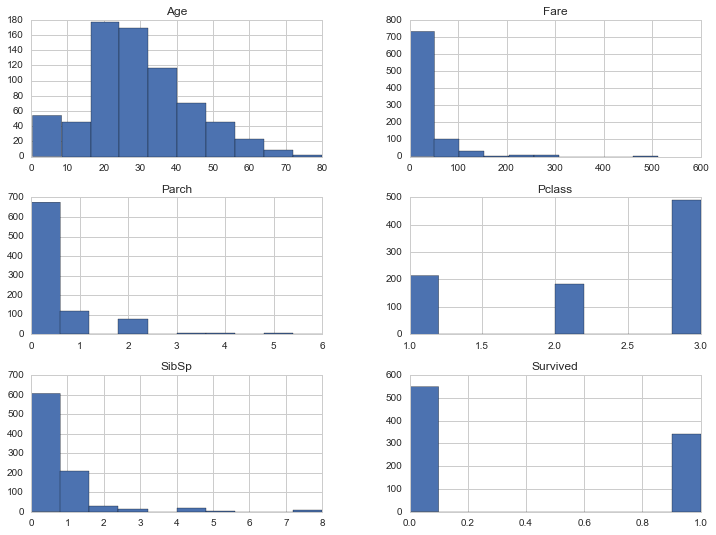

In [9]:
# Overall histogram summary
titanic_df.hist(figsize=(12,12), layout=(4,2));

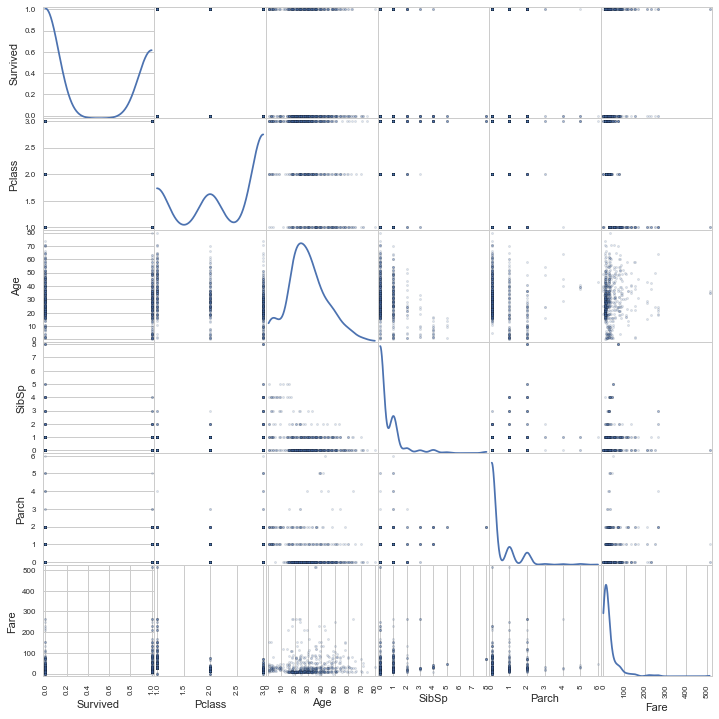

In [10]:
scatter_matrix(titanic_df, alpha=0.2, figsize=(12, 12), diagonal='kde');

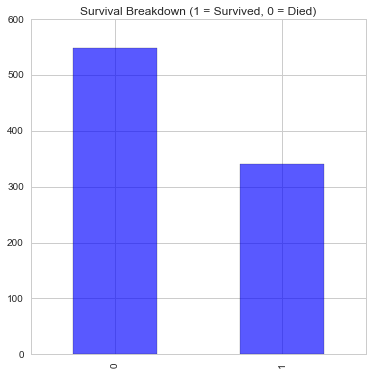

In [11]:
# Survival
plt.figure(figsize=(6,6))
titanic_df.Survived.value_counts().plot(kind='bar', color="blue", alpha=.65)
plt.title("Survival Breakdown (1 = Survived, 0 = Died)");

## Feature Visualisations and Basic Cleaning ##

Visualise the features and perform basic cleaning such as converting string columns.

In [12]:
# plot some basic graphs for the given feature
def basic_plots(feature):
    fig = plt.figure(figsize=(12,6))

    ax1 = plt.subplot2grid((1,2), (0,0))    
    df2=titanic_df.groupby([feature, 'Survived'])['Pclass'].count().unstack()
    df2.plot(kind='bar', ax=ax1, stacked=True)
 
    ax2 = plt.subplot2grid((1,2), (0,1))
    df = pd.DataFrame([
        titanic_df[titanic_df['Survived']==1][feature].value_counts(),
        titanic_df[titanic_df['Survived']==0][feature].value_counts()])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, ax=ax2)

    sns.factorplot(feature,'Survived',data=titanic_df,size=5);

### Pclass ###

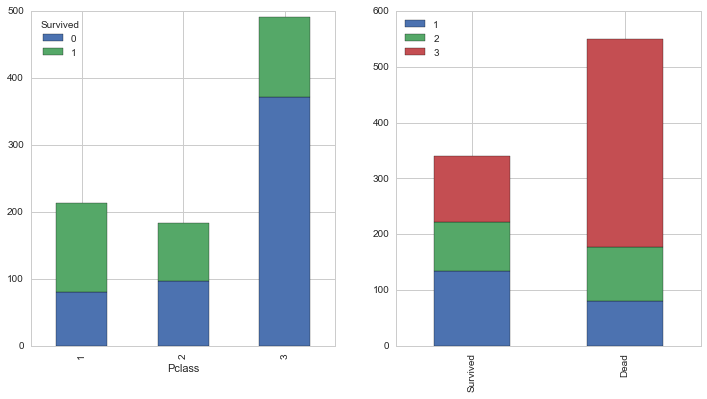

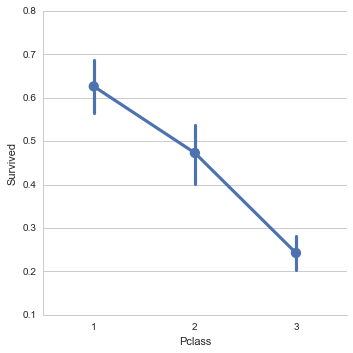

In [13]:
basic_plots('Pclass')

Here we can see that there is a higher probability of survival for Pclass values with a lower number

### Sex ###

In [24]:
women = titanic_df[titanic_df['Sex']==0]
print('Number of females: ', len(women))
men = titanic_df[titanic_df['Sex']==1]
print('Number of males: ', len(men))

proportion_women_survived = np.sum(women['Survived'].tolist()) / np.size(women['Survived'].tolist()) 
proportion_men_survived = np.sum(men['Survived'].tolist()) / np.size(men['Survived'].tolist()) 

print('Proportion of women who survived is %s' % proportion_women_survived)
print('Proportion of men who survived is %s' % proportion_men_survived)

Number of females:  312
Number of males:  577
Proportion of women who survived is 0.740384615385
Proportion of men who survived is 0.188908145581


In [25]:
pd.crosstab(titanic_df.Survived, titanic_df.Sex)

Sex,0,1
Survived,,
0,81,468
1,231,109


In [23]:
pd.crosstab(titanic_df.Survived, titanic_df.Sex, normalize=True)

Sex,0,1
Survived,,
0,0.091114,0.526434
1,0.259843,0.122610


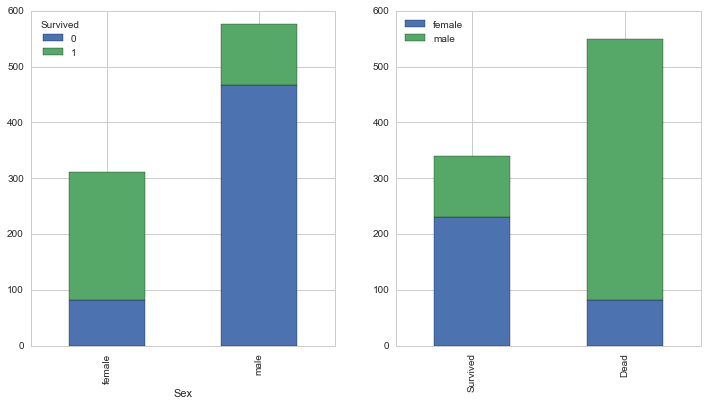

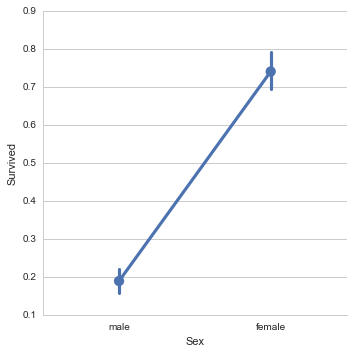

In [14]:
basic_plots('Sex')

Females had a much greater chance of survival

In [15]:
# mapping string values to numerical one 
titanic_df['Sex'] = titanic_df['Sex'].map({'male':1,'female':0})
test_df['Sex'] = test_df['Sex'].map({'male':1,'female':0})

### Age ###

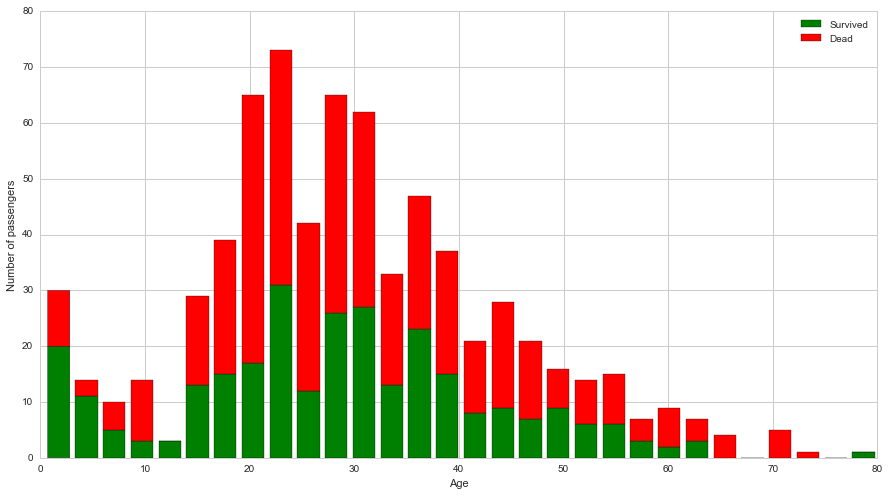

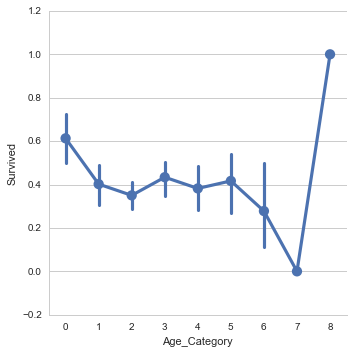

In [18]:
# There are many values missing. For now we want to only visualise those that are present so 
# we don't distort the picture so we drop all na values when visualising.
figure = plt.figure(figsize=(15,8))
df = titanic_df.dropna(subset=['Age'])
plt.hist([df[df['Survived']==1]['Age'],df[df['Survived']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

age_categories = pd.cut(df['Age'], [0,10,20,30,40,50,60,70,80,90], right=False, precision=0, labels=False)
age_categories.name="Age_Category"
df = pd.concat([df, age_categories], axis=1)
sns.factorplot('Age_Category','Survived',data=df,size=5);

It seems those aged less than 10 had the highest chance of survival, those aged 10-50 had a lower chance and then the survival possibility dropping off after age 50 with a few possible outliers aged 80+

In [ ]:
# TODO: Visualise and Analyse
# Name
# SibSp
# Parch
# Ticket
# Fare
# Cabin
# Embarked